# CoVLA-Dataset Tutorial

This tutorial aims to demonstrate how to load the CoVLA-Dataset. The dataset includes 10,000 driving videos spanning over 80 hours, along with corresponding vehicle states, captions, front car coordinates, and traffic light coordinates. The total size of the dataset exceeds 400GB. If you plan to use this dataset for your project, we recommend downloading it to your local storage.

In [ ]:
from datasets import load_dataset

# load the videos in streaming mode
dataset = load_dataset(
    "turing-motors/CoVLA-Dataset",
    split="train",
    streaming=True,
)

scene_id = 0 # Scene ID (0 to 9999)

for idx, scene in enumerate(dataset):
    if idx == scene_id:
        print(scene)
        break
    
#{'video': <decord.video_reader.VideoReader object at 0x15549018e630>, 'video_id': '0000b7dc6478371b'}


In [ ]:
import cv2

for idx, scene in enumerate(dataset):
    if idx == scene_id:
        video = scene["video"]
        video_id = scene["video_id"]
        break
        
output_file = f"{video_id}.mp4"

fps = 20
height, width, _ = video[0].shape

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_file, fourcc, fps, (width, height))

for frame_idx in range(len(video)):
    frame = video[frame_idx].asnumpy()
    frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    out.write(frame_bgr)

out.release()
print(f"Save the video: {output_file}")


Save the video: 0000b7dc6478371b.mp4


You can access each frame sampled at 20Hz using `.get_batch`.

scene_id: 0
frame_id: 0


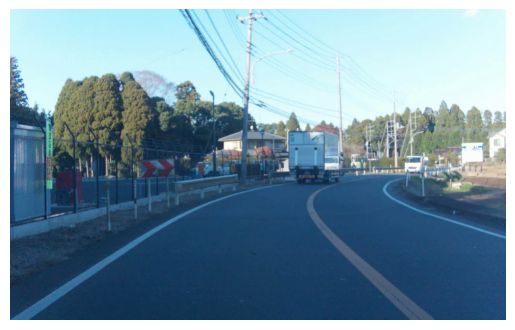

In [3]:
import matplotlib.pyplot as plt

# Frame ID within the scene (0 to 599 for a 30s clip at 20Hz)
frame_id = 0  

for idx, scene in enumerate(dataset):
    if idx == scene_id:
        video = scene["video"]
        break

frame = video.get_batch([frame_id]).asnumpy()[0]

print("scene_id:", scene_id)
print("frame_id:", frame_id)
plt.imshow(frame)
plt.axis("off")
plt.show()


We provide `states`, `captions`, `front_car` coordinates, and `traffic_lights` coordinates in JSONL format for each 20Hz frame of each video clip.

In [22]:
import json
import numpy as np

jsonl_file_path = "states/0000b7dc6478371b.jsonl"

with open(jsonl_file_path, "r", encoding="utf-8") as file:
    jsonl_data = [json.loads(line) for line in file]

for entry in jsonl_data:
    if "0" in entry:
        trajectory = entry["0"]["trajectory"]
        extrinsic_matrix = np.array(entry["0"]["extrinsic_matrix"])
        intrinsic_matrix = np.array(entry["0"]["intrinsic_matrix"])
        break
    
print("trajectory:", trajectory, "\n")
print("extrinsic_matrix:", extrinsic_matrix, "\n")
print("intrinsic_matrix:", intrinsic_matrix)


trajectory: [[0.0, -0.0, 0.0], [0.6754916294505826, -0.0004112955535602757, -0.003611497468541254], [1.2690413027344118, 0.009279287243222226, -0.00998454220423104], [1.9467867538195494, 0.008179032450453719, -0.012505771730551011], [2.596496537608562, 0.01877413860822715, -0.016015913135001215], [3.2344154844157598, 0.01950131243557854, -0.019628428181935338], [3.855882997506408, 0.029146093001235794, -0.025263625290303893], [4.533206418844693, 0.025870179774939165, -0.025789563880710884], [5.182432793344146, 0.03595924159505673, -0.029256555987830987], [5.793862260624657, 0.030644670723798513, -0.03509437396611816], [6.4848072872935685, 0.03568665262327893, -0.03830351808093917], [7.129033468543919, 0.02997622943214285, -0.03780833668089241], [7.782777798375551, 0.03698247248784131, -0.04320874207650175], [8.437143868723282, 0.029917256902382446, -0.045566770511582935], [9.106674075560266, 0.0332436980038327, -0.046547749166871606], [9.710846791346484, 0.02461250590311095, -0.0505435

You can plot the trajectory onto the video frame, as demonstrated below.

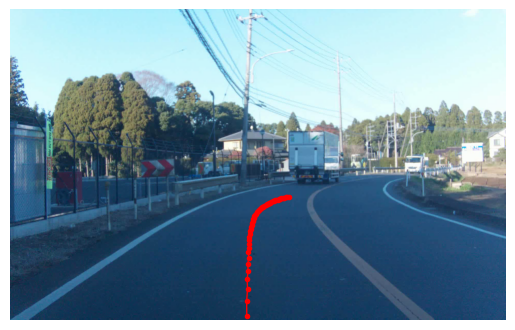

In [23]:
import matplotlib.pyplot as plt
import numpy as np

def device_to_camera(P_device, extrinsic_matrix):
    """Convert device coordinates to camera coordinates."""
    P_device_hom = np.append(P_device, 1)
    P_camera_hom = np.dot(extrinsic_matrix, P_device_hom)
    return P_camera_hom[:3]

def camera_to_image(P_camera, intrinsic_matrix):
    """Convert camera coordinates to image coordinates."""
    P_image_homogeneous = np.dot(intrinsic_matrix, P_camera)
    P_image = P_image_homogeneous[:2] / P_image_homogeneous[2]
    return P_image

def plot_trajectory_on_image(
    frame, trajectory, extrinsic_matrix, intrinsic_matrix, marker="o", color="red"
):
    # Convert device coordinates to camera coordinates
    future_pos_camera = np.array(
        [device_to_camera(p, extrinsic_matrix) for p in trajectory]
    )
    # Keep only points in front of the camera (z > 0)
    future_pos_camera = future_pos_camera[future_pos_camera[:, 2] > 0]

    # Convert camera coordinates to image coordinates
    future_pos_image = np.array(
        [camera_to_image(p, intrinsic_matrix) for p in future_pos_camera]
    )

    # Filter out points that are outside the image bounds
    image_height, image_width = frame.shape[:2]
    future_pos_image = future_pos_image[
        (future_pos_image[:, 0] >= 0) & (future_pos_image[:, 0] < image_width) &
        (future_pos_image[:, 1] >= 0) & (future_pos_image[:, 1] < image_height)
    ]

    plt.imshow(frame)
    plt.axis("off")
    if len(future_pos_image) > 0:
        plt.plot(
            future_pos_image[:, 0], future_pos_image[:, 1],
            marker=marker, color=color, linestyle="solid", linewidth=1, markersize=3,
        )
    plt.show()

plot_trajectory_on_image(
    frame=frame,
    trajectory=trajectory,
    extrinsic_matrix=extrinsic_matrix,
    intrinsic_matrix=intrinsic_matrix,
    marker="o",
    color="red"
)


In [26]:
import json

jsonl_file_path = "captions/0000b7dc6478371b.jsonl"

with open(jsonl_file_path, "r", encoding="utf-8") as file:
    jsonl_data = [json.loads(line) for line in file]

for idx, entry in enumerate(jsonl_data):
    if idx == 0:
        print(json.dumps(entry, indent=4, ensure_ascii=False))
        break


{
    "0": {
        "plain_caption": "The ego vehicle is moving straight at a high speed. There is no traffic light in the scene.",
        "rich_caption": "The ego vehicle is moving straight at a high speed. There is no traffic light in the scene. It is sunny. The car is driving on a narrow road. There is a car carrier truck. No pedestrians appear to be present. What the driver of ego vehicle should be careful is to maintain a safe distance from the car carrier truck and other vehicles on the road",
        "risk": "to maintain a safe distance from the car carrier truck and other vehicles on the road",
        "risk_correct": true,
        "risk_yes_rate": 0.7111786673145859,
        "weather": "sunny",
        "weather_rate": 0.8887758078845928,
        "road": "narrow road",
        "road_rate": 0.681667179604633,
        "is_tunnel": false,
        "is_tunnel_yes_rate": 0.11219189535951392,
        "is_highway": false,
        "is_highway_yes_rate": 0.2895749091274674,
        "ha

You can also load `traffic_lights` and `front_car` in the same way.